In [1]:
dbutils.library.installPyPI('snowflake-connector-python')
dbutils.library.installPyPI("azure-storage-blob")
dbutils.library.installPyPI("scikit-learn")
dbutils.library.installPyPI("mlflow")

dbutils.library.restartPython()

In [2]:
# Python Notebook - is_wait_prediction_v11
import os
import snowflake.connector

import numpy as np
import pandas as pd
from sklearn.metrics import log_loss, accuracy_score, average_precision_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize, Normalizer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from datetime import datetime, timedelta
from sklearn.feature_selection import RFECV
import collections
from datetime import date
import mlflow

%matplotlib inline

/local_disk0/pythonVirtualEnvDirs/virtualEnv-491542ef-cac4-4673-b0fa-9b148e2ce748/lib/python3.5/site-packages/snowflake/connector/options.py:40: UserWarning: You have an incompatible version of 'pyarrow' installed, please install a version that adheres to: 'pyarrow<0.18.0,>=0.17.0; extra == "pandas"'
 warn_incompatible_dep('pyarrow', _installed_pyarrow.version, _expected_version)
%matplotlib inline is not supported in Databricks.
You can display matplotlib figures using display(). For an example, see https://docs.databricks.com/user-guide/visualizations/matplotlib-and-ggplot.html

In [3]:
today = datetime.today().strftime('%Y%m%d')
print('today', today)

today 20200910

## Global variables

In [5]:
WAIT_THR = 6 * 60 #4min in prep_time_model
DELAY_THR = 0 * 60 #2min
WAIT_PENALTY = 1.0
DELAY_PENALTY = 1.25

today = datetime.today().strftime('%Y%m%d')
print('today', today)

SCALER_TYPE = 'standard' #'standard' 'minmax'
BALANCE = False

today 20200910

## Utils

In [7]:
def eval_model(y_test, y_pred, y_pred_proba):
  acc_score = accuracy_score(y_test, y_pred)
  logloss = log_loss(y_test, y_pred_proba)
  logloss_baseline = log_loss(y_test, np.zeros(len(y_test)))
  rocauc = roc_auc_score(y_test, y_pred_proba[:, 1])
  conf_mat = confusion_matrix(y_test, y_pred)
  tn, fp, fn, tp = conf_mat.ravel()

  print('true pct in testing data of no-wait', 1-y_test.mean(), 'vs wait', y_test.mean(), )
  print('acc', acc_score)
  print('log loss pred vs baseline', logloss, logloss_baseline)
  print('roc auc', rocauc)
  print('conf matrix (percentage of all data)\n', conf_mat/len(y_test))
  print("absolute values of tn", tn, "fp", fp, "fn", fn, "tp", tp)

def get_lr_feat_importance(X_train_scaled, clf):
  X_train_std = np.std(X_train_scaled, 0)

  importance_score = [i * j for i, j in zip (list(X_train_std), list(clf.coef_))][0]
  res = dict(zip(cols, list(importance_score)))
  res = {k: float(v) for k, v in sorted(res.items(), key=lambda item: abs(item[1]), reverse=True)}
  
#   sorted(res.items(), key=lambda x:x[1])
  print('Feature importance')
  print(res)
#   print(list(res.keys()))
#   print(list(res.values()))
  plt.figure()
  plt.bar(res.keys(), height=res.values())
  plt.xticks(rotation=90)

def calculate_score(y_test, y_pred, y_test_time):
  res = (y_test != y_pred) * y_test_time
  res = pd.DataFrame(data=res, columns=['time'])
  res['penalty'] = 0
  wait_index = res[res['time'] >= WAIT_THR].index #, 'penalty'] = WAIT_PENALTY
  late_index = res[res['time'] <= -DELAY_THR].index #, 'penalty'] = -DELAY_PENALTY
  
  res.loc[wait_index, 'time'] = res.loc[wait_index, 'time'] - WAIT_THR
  res.loc[late_index, 'time'] = DELAY_THR - res.loc[late_index, 'time'] 
  
  res.loc[wait_index, 'penalty'] = WAIT_PENALTY
  res.loc[late_index, 'penalty'] = DELAY_PENALTY
  
  res['score'] = res['time'] * res['penalty']
  score = res['score'].mean()
  
  pred_wait_but_late = res[(res['penalty'] != 0) & (res['time']  <= -DELAY_THR)]
  print('pred_wait_but_late', len(pred_wait_but_late), \
        'pct in all false predictions', len(pred_wait_but_late)/len(res[res['penalty'] != 0]), \
        'pct in all predictions', len(pred_wait_but_late)/len(res))
  return score


def eval_model_loss(y_test, y_pred, y_pred_proba, y_test_time):
  acc_score = accuracy_score(y_test, y_pred)
  logloss = log_loss(y_test, y_pred_proba)
  logloss_baseline = log_loss(y_test, np.zeros(len(y_test)))
  rocauc = roc_auc_score(y_test, y_pred_proba[:, 1])
  conf_mat = confusion_matrix(y_test, y_pred)
  tn, fp, fn, tp = conf_mat.ravel()
  score = calculate_score(y_test, y_pred, y_test_time)
  
  print('true pct in testing data of no-wait', 1-y_test.mean(), 'vs wait', y_test.mean(), )
  print('acc', acc_score)
  print('log loss pred vs baseline', logloss, logloss_baseline)
  print('roc auc', rocauc)
  print('conf matrix (percentage of all data)\n', conf_mat/len(y_test))
  print("absolute values of tn", tn, "fp", fp, "fn", fn, "tp", tp)
  print("score", score)
  
  return conf_mat

def scale_data(X_train, X_test, scaler_type):
  X_train_scaled = X_train.copy()
  X_test_scaled = X_test.copy()
  
  if scaler_type == 'minmax':
    scaler = MinMaxScaler()
  elif scaler_type == 'standard':
    scaler = StandardScaler()
    
  scaler.fit(X_train)

  X_train_scaled = scaler.transform(X_train)
  X_test_scaled = scaler.transform(X_test)
    
  return X_train_scaled, X_test_scaled

def create_store_level_hist_feat(df):
#   d = {'wait_before_ready_time': ['mean', 'min', 'max'], 
#        'd2r_duration': ['mean', 'min', 'max'], 
#        'pred_horizon': ['mean', 'min', 'max']}
  d = {'wait_before_ready_time': ['mean', 'median', 'min', 'max'], 
       'd2r_duration': ['mean', 'median', 'min', 'max'], 
       'pred_horizon': ['mean', 'median', 'min', 'max']}  
  df_agg = df.groupby(['store_id'], as_index=False).agg(d)
  
  df_agg.columns = ["_".join(x) for x in df_agg.columns.ravel()]
  df_agg.rename(columns={'store_id_':'store_id'}, inplace=True)
  
  df_hist = pd.merge(df, df_agg, on=['store_id'], how='left')
  return df_hist 


def fill_with_mean(df):
  print('before filling na with mean', df.isnull().sum() / len(df))
  return df.fillna(df.mean(), inplace=False)


def calculate_bad_false_alarm(y_test, y_pred, y_test_time):
  y_test_time <= DELAY_THR
  
  res = pd.DataFrame()
  
  assert all(y_test.index == y_test_time.index), 'unmatched index'
  res = pd.concat([y_test, y_test_time], axis=1)
  assert y_test.shape[0] == res.shape[0], 'unequal index'
  
  res['y_pred'] = y_pred
    
  print(res.head(5))

  pred_wait_but_late_index = res[(res['label_int']==0) & (res['y_pred']==1) & (res['wait_before_ready_time'] <= DELAY_THR)].index
  pred_wait_but_ontime_index = res[(res['label_int']==0) & (res['y_pred']==1) & (res['wait_before_ready_time'] > DELAY_THR)].index
  
  fpr_late = len(pred_wait_but_late_index)/ len(res)
  print('bad false positive rate (all data)', fpr_late)
  fpr_ontime = len(pred_wait_but_ontime_index)/ len(res)
  print('okay false positive rate (pred wait data)', fpr_ontime)

  pred_wait_but_late = res.loc[pred_wait_but_late_index]
  pred_wait_but_ontime = res.loc[pred_wait_but_ontime_index]
  
  fpr_late_time = pred_wait_but_late['wait_before_ready_time'].mean()
  fpr_ontime_time = pred_wait_but_ontime['wait_before_ready_time'].mean()
  print('mean late time', fpr_late_time)
  print('mean ontime time', fpr_ontime_time)
  
  return fpr_late, fpr_late_time, fpr_ontime, fpr_ontime_time

## Fetch data

In [9]:
user = dbutils.secrets.get(scope="chizhang-scope", key="snowflake-user")
password = dbutils.secrets.get(scope="chizhang-scope", key="snowflake-password")

os.environ['SNOWFLAKE_USER'] = dbutils.secrets.get(scope="chizhang-scope", key="snowflake-user")
os.environ['SNOWFLAKE_PW'] = dbutils.secrets.get(scope="chizhang-scope", key="snowflake-password")

params = dict(
  user=user,
  password=password,
  account='DOORDASH',
  database='PRODDB',
  warehouse='ADHOC',
  schema='public',
)

# sql_query = """ select * from CHIZHANG.pred_wait_final_0820_remove_store """

# with snowflake.connector.connect(**params) as ctx:
#     raw_data = pd.read_sql(sql_query, ctx)
#     raw_data.to_csv('/dbfs/chizhang/is_wait_prediction/data/{}.csv'.format(today))

In [10]:
raw_data = pd.read_csv("/dbfs/chizhang/is_wait_prediction/data/20200820.csv")

In [11]:
df = raw_data.copy()
df.columns = map(str.lower, df.columns)
raw_data_size = df.shape
print("raw_data_size", raw_data_size)
print(df.head(5))

raw_data_size (2581296, 30)
 unnamed: 0 original_timestamp delivery_id \
0 0 2020-07-14 01:12:35.935000 744710261 
1 1 2020-07-13 00:41:08.676000 742359325 
2 2 2020-07-13 19:20:00.750000 743632659 
3 3 2020-07-10 19:05:22.557000 735790983 
4 4 2020-07-10 02:16:02.808000 734637645 

 first_assignment_time_utc acceptance_rate_on_check_in \
0 2020-07-14 01:12:35.935000 68.0 
1 2020-07-13 00:41:08.676000 27.0 
2 2020-07-13 19:20:00.750000 75.0 
3 2020-07-10 19:05:22.557000 1.0 
4 2020-07-10 02:16:02.808000 75.0 

 order_ready_time_utc assignment_run_id flf \
0 2020-07-14 01:22:04.000000 dra:DAL_20_1594689147111 0.990909 
1 2020-07-13 00:52:38.000000 dra:NYC_85_1594600862957 1.367188 
2 2020-07-13 19:20:31.000000 dra:PHL_131_1594667998579 1.008929 
3 2020-07-10 19:16:38.000000 dra:RVA_54_1594407918160 0.840000 
4 2020-07-10 02:23:40.000000 dra:LA_81_1594347354339 1.144444 

 created_at actual_pickup_time ... \
0 2020-07-14 01:11:53.528701 2020-07-14 01:28:40.831000 ... 
1 2020-07-13 00:31:09.769965 2020-07-13 00:55:24.465000 ... 
2 2020-07-13 19:04:41.871141 2020-07-13 19:42:45.362000 ... 
3 2020-07-10 19:04:16.021940 2020-07-10 19:24:45.444000 ... 
4 2020-07-10 02:15:36.603389 2020-07-10 02:20:13.038000 ... 

 ext_point_long wait_before_ready_time avg_num_assigns avg_subtotal \
0 -96.697359 270.0 2.468750 2249.875000 
1 -74.030077 118.0 2.523643 4692.977233 
2 -76.855507 -421.0 1.315789 3157.894737 
3 -77.410611 -302.0 2.888889 2271.814815 
4 -118.589053 325.0 2.166667 1264.750000 

 avg_tip avg_d2r_duration num_nearby_idle est_d2r_first \
0 462.500000 242.593750 2 551.889 
1 651.234676 257.191150 2 321.043 
2 452.631579 258.526316 1 644.421 
3 322.388889 357.444444 4 666.840 
4 191.666667 245.083333 1 642.661 

 est_d2r_second est_d2r_third 
0 700.889 NaN 
1 525.043 NaN 
2 NaN NaN 
3 716.840 726.84 
4 NaN NaN 

[5 rows x 30 columns]

In [12]:
df.columns

Out[ 8 ]: Index(['unnamed: 0', 'original_timestamp', 'delivery_id',
 'first_assignment_time_utc', 'acceptance_rate_on_check_in',
 'order_ready_time_utc', 'assignment_run_id', 'flf', 'created_at',
 'actual_pickup_time', 'dasher_at_store_time', 'pred_horizon',
 'd2r_duration', 'subtotal', 'tip', 'store_id', 'num_assigns',
 'pickup_address_id', 'create_to_arrive', 'ext_point_lat',
 'ext_point_long', 'wait_before_ready_time', 'avg_num_assigns',
 'avg_subtotal', 'avg_tip', 'avg_d2r_duration', 'num_nearby_idle',
 'est_d2r_first', 'est_d2r_second', 'est_d2r_third'],
 dtype='object')

### change labels: 1 - 25m geo. 2 - new optimal arrival time

In [14]:
# 25m geo
# df['wait_before_ready_time'] = (pd.to_datetime(df['order_ready_time_utc']) - pd.to_datetime(df['dasher_at_store_25m'])).dt.total_seconds()

# new optimal arrival time, use column create_to_arrive, 165 has been subtracted from create_to_arrive.
df['creat_to_actual_dasher_at_store'] = (pd.to_datetime(df['dasher_at_store_time']) - pd.to_datetime(df['created_at'])).dt.total_seconds()
df['wait_before_ready_time'] = df['create_to_arrive'] - df['creat_to_actual_dasher_at_store'] #created_to_arrive is from new mx pickup logistic model
df['wait_before_ready_time'].head(10)

Out[ 9 ]: 0 105.099695
1 -46.955571
2 -585.537784
3 -467.317126
4 160.047575
5 -309.512935
6 272.946659
7 110.681928
8 287.200434
9 -99.360740
Name: wait_before_ready_time, dtype: float64

### Clean data

#### estimated d2r has nulls, filling with average

In [17]:
df[['est_d2r_first', 'est_d2r_second', 'est_d2r_third']] = fill_with_mean(df[['est_d2r_first', 'est_d2r_second', 'est_d2r_third']] )

before filling na with mean est_d2r_first 0.018839
est_d2r_second 0.328335
est_d2r_third 0.499105
dtype: float64

In [18]:
f = 'pred_horizon'
print('before cleaning, shape is', df.shape)
df_clean = df.copy()
df_clean = df_clean[df_clean['flf'] < 5]
df_clean = df_clean[(df_clean['pred_horizon'] < 60 * 60) & (df_clean['pred_horizon'] >= 0)]
df_clean = df_clean[df_clean['est_d2r_first'] >= 0]
df_clean = df_clean[df_clean['est_d2r_second'] >= 0]
df_clean = df_clean[df_clean['tip'] <= 40000]

print('after remove pred_horizon and flf, now shapeis ', df_clean.shape)

df_clean[f].min(), df_clean[f].max()

## Outlier removal
print(">>> check NAs")
print(df.isnull().sum() / len(df))

print(">>> remove data with invalid lables")
df_clean = df_clean[df_clean['wait_before_ready_time'].notnull()]
df_clean.reindex()
print('>>> after dropping NAs in wait_time (label)', df_clean.shape, 1-df_clean.shape[0]/raw_data_size[0])

print('>>> drop NA with 0')
df_clean.dropna(inplace=True)
# df_clean = df_clean.fillna(0)

print('>>> after dropping NAs in other columns', df_clean.shape, 1-df_clean.shape[0]/raw_data_size[0])

df = df_clean
print(">>> check if na?", df.isnull().values.any())

df = create_store_level_hist_feat(df)
print(">>> adding agg features")
print(df.columns)

before cleaning, shape is (2581296, 31)
after remove pred_horizon and flf, now shapeis (2427901, 31)
>>> check NAs
unnamed: 0 0.000000
original_timestamp 0.000000
delivery_id 0.000000
first_assignment_time_utc 0.000000
acceptance_rate_on_check_in 0.000000
order_ready_time_utc 0.000000
assignment_run_id 0.000000
flf 0.000000
created_at 0.000000
actual_pickup_time 0.000000
dasher_at_store_time 0.020590
pred_horizon 0.000000
d2r_duration 0.020591
subtotal 0.000000
tip 0.000000
store_id 0.000000
num_assigns 0.000000
pickup_address_id 0.000000
create_to_arrive 0.000000
ext_point_lat 0.000000
ext_point_long 0.000000
wait_before_ready_time 0.020590
avg_num_assigns 0.000000
avg_subtotal 0.000000
avg_tip 0.000000
avg_d2r_duration 0.000464
num_nearby_idle 0.000000
est_d2r_first 0.000000
est_d2r_second 0.000000
est_d2r_third 0.000000
creat_to_actual_dasher_at_store 0.020590
dtype: float64
>>> remove data with invalid lables
>>> after dropping NAs in wait_time (label) (2378138, 31) 0.07870387588250238
>>> drop NA with 0
>>> after dropping NAs in other columns (2378136, 31) 0.07870465068709676
>>> check if na? False
>>> adding agg features
Index(['unnamed: 0', 'original_timestamp', 'delivery_id',
 'first_assignment_time_utc', 'acceptance_rate_on_check_in',
 'order_ready_time_utc', 'assignment_run_id', 'flf', 'created_at',
 'actual_pickup_time', 'dasher_at_store_time', 'pred_horizon',
 'd2r_duration', 'subtotal', 'tip', 'store_id', 'num_assigns',
 'pickup_address_id', 'create_to_arrive', 'ext_point_lat',
 'ext_point_long', 'wait_before_ready_time', 'avg_num_assigns',
 'avg_subtotal', 'avg_tip', 'avg_d2r_duration', 'num_nearby_idle',
 'est_d2r_first', 'est_d2r_second', 'est_d2r_third',
 'creat_to_actual_dasher_at_store', 'wait_before_ready_time_mean',
 'wait_before_ready_time_median', 'wait_before_ready_time_min',
 'wait_before_ready_time_max', 'd2r_duration_mean',
 'd2r_duration_median', 'd2r_duration_min', 'd2r_duration_max',
 'pred_horizon_mean', 'pred_horizon_median', 'pred_horizon_min',
 'pred_horizon_max'],
 dtype='object')

In [19]:
df.head(5)

,unnamed: 0,original_timestamp,delivery_id,first_assignment_time_utc,acceptance_rate_on_check_in,order_ready_time_utc,assignment_run_id,flf,created_at,actual_pickup_time,...,wait_before_ready_time_min,wait_before_ready_time_max,d2r_duration_mean,d2r_duration_median,d2r_duration_min,d2r_duration_max,pred_horizon_mean,pred_horizon_median,pred_horizon_min,pred_horizon_max
0,0,2020-07-14 01:12:35.935000,744710261,2020-07-14 01:12:35.935000,68.0,2020-07-14 01:22:04.000000,dra:DAL_20_1594689147111,0.990909,2020-07-14 01:11:53.528701,2020-07-14 01:28:40.831000,...,-760.546832,401.180751,200.045455,198.0,1.0,752.0,582.818182,579.0,506,766
1,1,2020-07-13 00:41:08.676000,742359325,2020-07-13 00:41:08.676000,27.0,2020-07-13 00:52:38.000000,dra:NYC_85_1594600862957,1.367188,2020-07-13 00:31:09.769965,2020-07-13 00:55:24.465000,...,-4098.228000,727.748559,243.272727,214.0,0.0,1893.0,678.731707,698.0,350,1004
2,2,2020-07-13 19:20:00.750000,743632659,2020-07-13 19:20:00.750000,75.0,2020-07-13 19:20:31.000000,dra:PHL_131_1594667998579,1.008929,2020-07-13 19:04:41.871141,2020-07-13 19:42:45.362000,...,-717.763381,539.500119,301.500000,168.5,66.0,1285.0,686.600000,763.5,31,790
3,3,2020-07-10 19:05:22.557000,735790983,2020-07-10 19:05:22.557000,1.0,2020-07-10 19:16:38.000000,dra:RVA_54_1594407918160,0.840000,2020-07-10 19:04:16.021940,2020-07-10 19:24:45.444000,...,-1645.542910,442.531239,384.742857,243.0,41.0,1841.0,640.542857,671.0,294,707
4,4,2020-07-10 02:16:02.808000,734637645,2020-07-10 02:16:02.808000,75.0,2020-07-10 02:23:40.000000,dra:LA_81_1594347354339,1.144444,2020-07-10 02:15:36.603389,2020-07-10 02:20:13.038000,...,-624.856672,251.247303,245.083333,248.0,26.0,466.0,501.666667,519.5,442,538


## Create labels

In [21]:
# add lateness labels
df['label'] = "ontime"
df.loc[df['wait_before_ready_time'] >= WAIT_THR, 'label'] = 'early'
df.loc[df['wait_before_ready_time'] <= -DELAY_THR, 'label'] = 'late'

df['label_int'] = 0
df.loc[df['label'] == 'early', 'label_int'] = 1

# assert (df['label_int'].value_counts(normalize=True).values ==  df['label'].value_counts(normalize=True).values).all(), "error in converting str label to int label"

print('Percentage of labels')
print(df['label'].value_counts(normalize=True))
print(df['label_int'].value_counts(normalize=True))

Percentage of labels
ontime 0.455842
late 0.291890
early 0.252268
Name: label, dtype: float64
0 0.747732
1 0.252268
Name: label_int, dtype: float64

## Select features

In [23]:
feat_hist_agg = ['d2r_duration_median', 
                 'avg_num_assigns']               
feat_real_time = ['tip', 'flf', 'pred_horizon', 'est_d2r_first', 'num_nearby_idle']
feat_manual = feat_hist_agg + feat_real_time

In [24]:
cols = feat_hist_agg + feat_real_time
for f in cols:
  df[f] = df[f].astype('float32')

## Split train/test

In [26]:
def balance_label(df):
  df_minor = df[df['label_int'] == 1]
  df_major = df[df['label_int'] == 0]
  
#   print(len(df_minor), len(df_major))
  df_major_downsample = df_major.sample(len(df_minor))

  assert len(df_major_downsample.index.intersection(df_minor.index)) == 0 , 'wrong index'
  
  idx = df_major_downsample.index.union(df_minor.index)
  print(len(df.loc[df_major_downsample.index]), len(df.loc[df_minor.index]))
  
  return idx

In [27]:
#method 1: time based split
# df['created_at'] = pd.to_datetime(df['created_at'])
# date_train_end = df['created_at'].dt.date.max() - timedelta(weeks=1)

# train_index = df[df['created_at'] <= date_train_end].index
# test_index = df[df['created_at'] > date_train_end].index

#method 2: random split
train_index, test_index = train_test_split(df.index, test_size=0.3, random_state=42)

# if balance or not?
if BALANCE:
  train_index = balance_label(df.loc[train_index])

# check leakage
assert len(train_index.intersection(test_index)) != [], 'data leakage'
print('train data size', len(train_index), 'date', df.loc[train_index, 'created_at'].min(), df.loc[train_index, 'created_at'].max())
print('test data size', len(test_index), 'date', df.loc[test_index, 'created_at'].min(), df.loc[test_index, 'created_at'].max())

X_train = df.loc[train_index, cols]
y_train = df.loc[train_index, 'label_int']
y_train_time = df.loc[train_index, 'wait_before_ready_time']


X_test = df.loc[test_index, cols]
y_test = df.loc[test_index, 'label_int']
y_test_time = df.loc[test_index, 'wait_before_ready_time']

train data size 1664695 date 2020-07-09 22:36:15.872573 2020-07-15 23:59:36.724927
test data size 713441 date 2020-07-09 22:59:12.768823 2020-07-15 23:59:30.625631

## Plot raw correlation

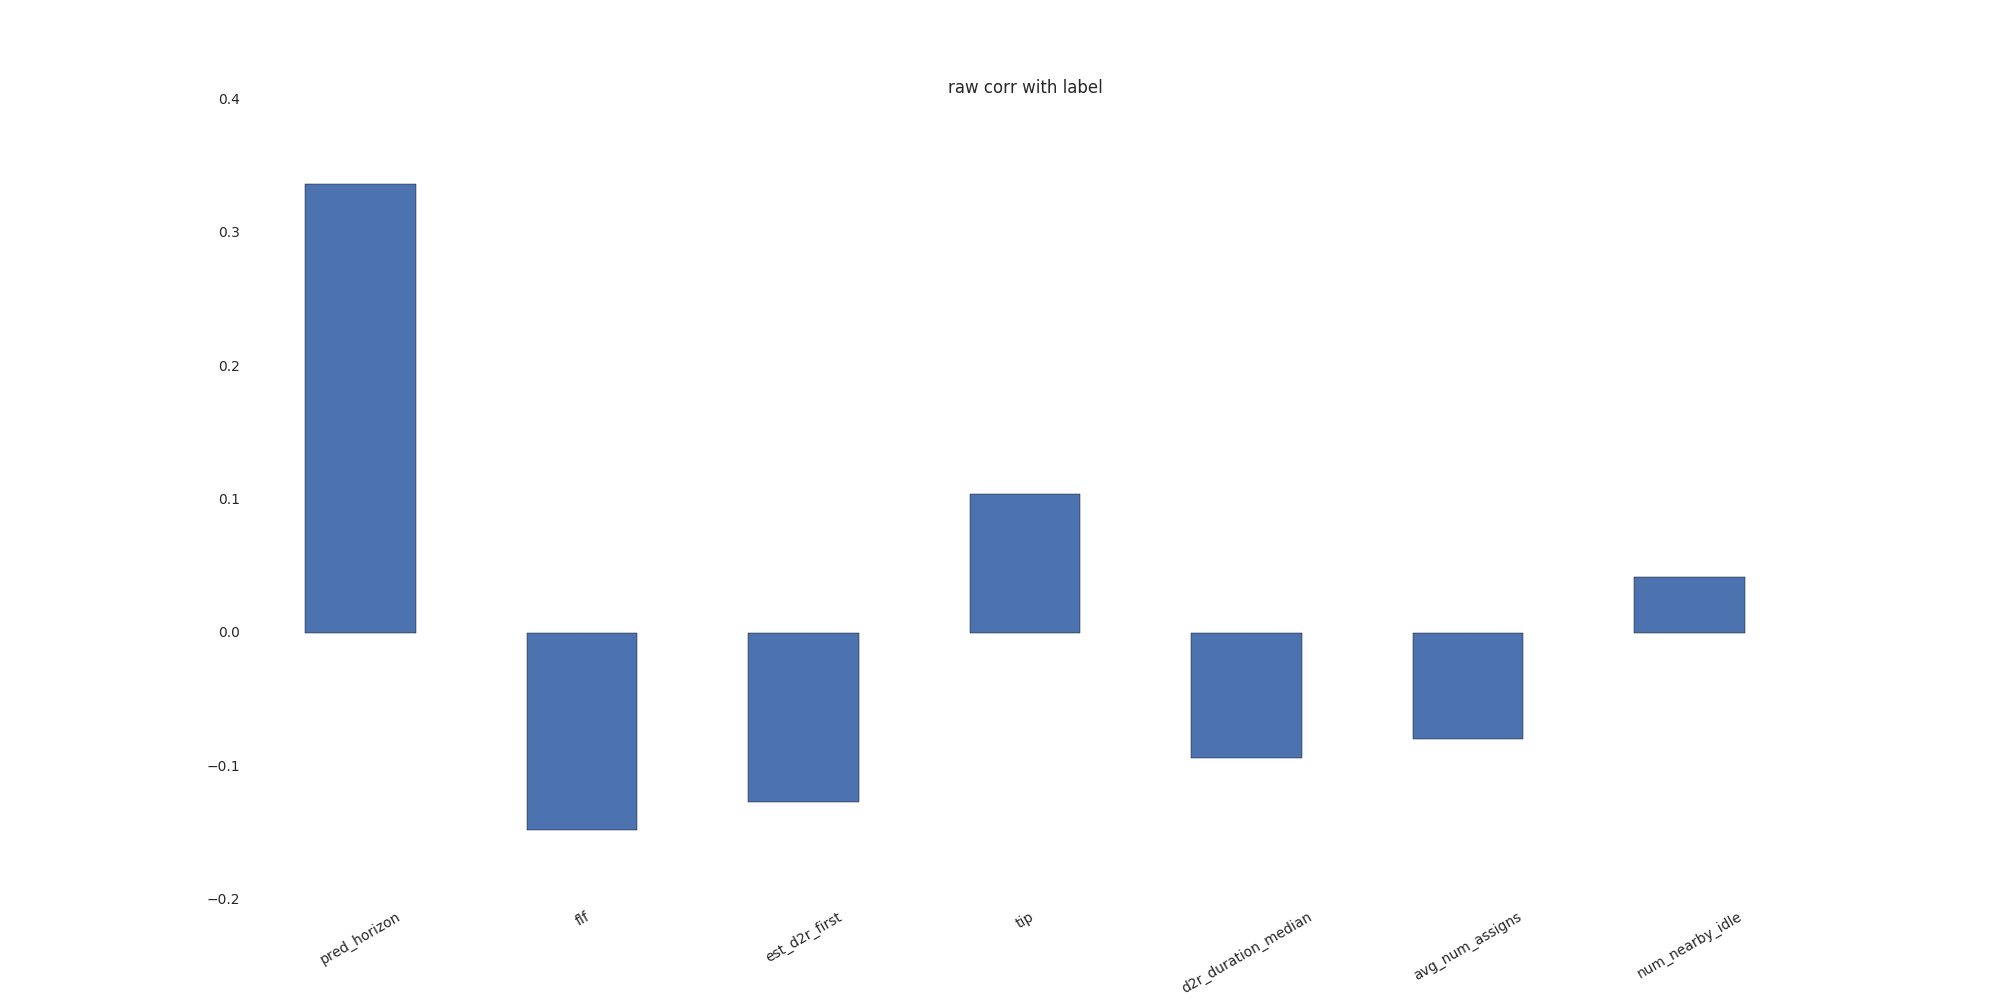

In [29]:
plt.figure()
sorted_corr_col = df[cols+['label_int']].corr()['label_int'].abs().sort_values(ascending=False).index
fig = df[sorted_corr_col].corr()['label_int'][1:].plot.bar(rot=30, title="raw corr with label", figsize=(20,10))
display()

## Model training, default

In [31]:
# standard - 45.96
# minmax - 46.04
# normalize 54.13
# for st in ['minmax', 'standard']:
run_name = str(today) + 'remove_instant'
with mlflow.start_run(run_name=run_name):

  threshold = 0.45
  class_weight = 'balanced' #'balanced' #None


  X_train_scaled_st, X_test_scaled_st = scale_data(X_train, X_test, scaler_type=SCALER_TYPE)

  clf_default = LogisticRegression(random_state=0, class_weight=class_weight)
  clf_default.fit(X_train_scaled_st, y_train)

  y_pred_proba_default = clf_default.predict_proba(X_test_scaled_st)
  y_pred_default = np.where(y_pred_proba_default[:,1] > threshold, 1, 0)
  print(">>> Train with default LR model", 'scaler_type', SCALER_TYPE)
  conf_mat = eval_model_loss(y_test, y_pred_default, y_pred_proba_default, y_test_time)
  fpr_late, fpr_late_time, fpr_ontime, fpr_ontime_time = calculate_bad_false_alarm(y_test, y_pred_default, y_test_time)

  mlflow.log_param("SCALER_TYPE", SCALER_TYPE)
  mlflow.log_param("BALANCE", BALANCE)

  mlflow.log_param("threshold", threshold)
  mlflow.log_param("class_weight", class_weight)
  mlflow.log_param("cols", cols)

  mlflow.log_metric("conf_mat_true_non_wait_pred_non_wait", conf_mat[0][0]/np.sum(conf_mat))
  mlflow.log_metric("conf_mat_true_non_wait_pred_wait", conf_mat[0][1]/np.sum(conf_mat))
  mlflow.log_metric("conf_mat_true_wait_pred_non_wait", conf_mat[1][0]/np.sum(conf_mat))
  mlflow.log_metric("conf_mat_true_wait_pred_wait", conf_mat[1][1]/np.sum(conf_mat))
  
  mlflow.log_metric("fpr_late", fpr_late)
  mlflow.log_metric("fpr_late_time", fpr_late_time)
  mlflow.log_metric("fpr_ontime", fpr_ontime)
  mlflow.log_metric("fpr_ontime_time", fpr_ontime_time)



>>> Train with default LR model scaler_type standard
pred_wait_but_late 496009 pct in all false predictions 0.8383486858784754 pct in all predictions 0.6952347846563346
true pct in testing data of no-wait 0.74788244578 vs wait 0.25211755422
acc 0.695234784656
log loss pred vs baseline 0.555140564995 8.70783183042
roc auc 0.799453957438
conf matrix (percentage of all data)
 [[ 0.49612372 0.25175873]
 [ 0.05300649 0.19911107]]
absolute values of tn 353955 fp 179615 fn 37817 tp 142054
score 42.4290300781
 label_int wait_before_ready_time y_pred
1274615 0 116.160140 0
577038 0 -212.898898 0
428937 0 273.881044 0
1901990 0 -716.248009 0
1003814 0 213.901627 0
bad false positive rate (all data) 0.0810494490784802
okay false positive rate (pred wait data) 0.1707092807954687
mean late time -385.311052787
mean ontime time 218.045538821

In [32]:
# get_lr_feat_importance(X_train_scaled_st, clf_default)

## Model extraction

In [34]:
# clf = clf_best
clf = clf_default
X_train_scaled = X_train_scaled_st
X_test_scaled = X_test_scaled_st


df_train_scaled = pd.DataFrame(data=X_train_scaled, columns=X_train.columns, index=X_train.index)
# df_train_scaled = X_train

assert all(df_train_scaled.index == train_index), 'X_train index and train_index do not match'

X_train_store_id = df.loc[train_index]['store_id'].to_frame().join(df_train_scaled)
X_train_store_id_agg = X_train_store_id[ ['store_id'] + feat_hist_agg]

print(X_train_store_id_agg.head(5))

num_stores = X_train_store_id_agg['store_id'].nunique()

df_store_level = X_train_store_id_agg.drop_duplicates(keep='first')
print('num_stores', num_stores, df_store_level.shape[0])
assert df_store_level.shape[0] == num_stores, 'unmatched after dropping dup'

coef = clf.coef_[0]
coef_hist_agg = coef[:len(feat_hist_agg)]
coef_real_time = coef[:-len(feat_real_time)]
print(coef)

intercept = clf.intercept_[0]
print(intercept)

model_coef = {}
# for i in range(len(feat_real_time)):
#   model_coef[feat_real_time[i]] = clf.coef_[0][i+len(feat_hist_agg)]
# model_coef
for i in range(len(cols)):
  model_coef[cols[i]] = clf.coef_[0][i]
model_coef

hist_agg_value = df_store_level[feat_hist_agg] * coef_hist_agg
hist_agg_value['intercept'] = intercept
hist_agg_value = hist_agg_value.sum(axis=1)
hist_agg_value = hist_agg_value.to_frame()
hist_agg_value.columns = ['value']
print(hist_agg_value)

assert all(df_store_level.index == hist_agg_value.index), 'unmatched index'

df_pre_calculated_value = df_store_level['store_id'].to_frame().join(hist_agg_value)
print(df_pre_calculated_value)

default_value = df_pre_calculated_value['value'].mean()
df_pre_calculated_value.loc[len(df_pre_calculated_value)]=['-1', default_value] 
df_pre_calculated_value.tail(4)

# import notebooksalamode as mode
# mode.export_csv(df_pre_calculated_value)
df_pre_calculated_value.to_csv('/dbfs/chizhang/is_wait_prediction/model/{}.csv'.format(today))

store_id d2r_duration_median avg_num_assigns
1559507 99391 -0.045452 -0.093302
312880 379373 -0.274525 0.086893
1362774 647517 -0.865853 0.471308
1350432 18375 -0.109379 -0.505470
391047 67299 -1.068290 -0.462272
num_stores 158857 158857
[-0.56283257 -0.36452801 0.18847498 -0.29656866 1.36680329 -0.34624597
 0.02437749]
-0.32985674453387503
 value
1559507 -0.270264
312880 -0.207020
1362774 -0.014331
1350432 -0.084037
391047 0.439923
... ...
1533584 0.954122
1474271 -7.878818
1641249 -0.904060
645263 -0.752239
2219110 0.226909

[158857 rows x 1 columns]
 store_id value
1559507 99391 -0.270264
312880 379373 -0.207020
1362774 647517 -0.014331
1350432 18375 -0.084037
391047 67299 0.439923
... ... ...
1533584 970297 0.954122
1474271 390204 -7.878818
1641249 733464 -0.904060
645263 716109 -0.752239
2219110 652912 0.226909

[158857 rows x 2 columns]

In [35]:
dbutils.fs.ls("dbfs:/chizhang/is_wait_prediction/model/{}.csv".format(today))


Out[142]: [FileInfo(path='dbfs:/chizhang/is_wait_prediction/model/20200820.csv', name='20200820.csv', size=5453479)]

## Model testing

In [37]:
df_pre_calculated_value.head(5)

model_min = {}
model_max = {}
model_mean = {}
model_std = {}

if SCALER_TYPE == 'minmax':
  for f in cols:
    # print('feature:', f, '\n\tmin:', X_train[f].min(), 'max:',  X_train[f].max())
    model_min[f] = X_train[f].min()
    model_max[f] = X_train[f].max()
elif SCALER_TYPE == 'standard':
  for f in cols:
    # print('feature:', f, '\n\tmean:', X_train[f].mean(), 'std:',  X_train[f].std())
    model_mean[f] = X_train[f].mean()
    model_std[f] = X_train[f].std()    

print('model_mean', model_mean)
print('model_std', model_std)

print('model_min', model_min)
print('model_max', model_max)

print('model_coef', model_coef)
valid_X_test = df.loc[test_index][['store_id'] + cols]

assert X_test.shape[0] == valid_X_test.shape[0], 'unmatched shape'

model_mean {'d2r_duration_median': 213.26595, 'avg_num_assigns': 2.1276677, 'tip': 443.88757, 'flf': 1.1195239, 'pred_horizon': 702.4031, 'est_d2r_first': 428.4799, 'num_nearby_idle': 3.4517055}
model_std {'d2r_duration_median': 93.85648, 'avg_num_assigns': 0.8324341, 'tip': 331.48358, 'flf': 0.34162417, 'pred_horizon': 166.91965, 'est_d2r_first': 153.67674, 'num_nearby_idle': 4.177637}
model_min {}
model_max {}
model_coef {'d2r_duration_median': -0.5628325668565225, 'avg_num_assigns': -0.36452800665286456, 'tip': 0.18847498163656873, 'flf': -0.29656865635470986, 'pred_horizon': 1.3668032904378111, 'est_d2r_first': -0.3462459676969633, 'num_nearby_idle': 0.02437749098354432}

In [38]:
# check how many stores in training not in testing
# and how many stores in testing not in training
valid_X_test = df.loc[test_index][['store_id'] + cols]
pre_cal_store = df_pre_calculated_value['store_id'].unique()

tmp = valid_X_test["store_id"].unique()

# print(pre_cal_store.shape, tmp.shape)

print('in pre_cal not in testing', len(set(pre_cal_store) - set(tmp)))
print('in testing not in pre_cal', len(set(tmp) - set(pre_cal_store)), 'pct', len(set(tmp) - set(pre_cal_store))/len(pre_cal_store))

in pre_cal not in testing 36145
in testing not in pre_cal 9139 pct 0.05752936584874542

In [39]:
valid_X_test_pre_cal = pd.merge(valid_X_test, df_pre_calculated_value, on='store_id', how='left')
assert valid_X_test_pre_cal.shape[0] == valid_X_test.shape[0], 'unmatched shape'
assert valid_X_test_pre_cal.isnull().sum().any(), 'na found'

print('before fill na', valid_X_test_pre_cal['value'].isnull().sum())
valid_X_test_pre_cal['value'] = valid_X_test_pre_cal['value'].fillna(value=default_value)
print('after fill na' ,valid_X_test_pre_cal['value'].isnull().sum())

result = valid_X_test_pre_cal['value'].copy()
if SCALER_TYPE == 'standard':
  for f in feat_real_time:
    result += model_coef[f] * (valid_X_test_pre_cal[f] - model_mean[f])/model_std[f]
elif SCALER_TYPE == 'minmax':
    result += model_coef[f] * (valid_X_test_pre_cal[f] - model_min[f])/model_max[f]
  
assert result.shape[0] == X_test.shape[0], 'unmatched shape'
proba = 1/(1+np.exp(-result))
# proba
binary = proba > threshold
print(1 - np.mean(binary))

print('matched predictions between saved csv and online testing', np.mean(binary == y_pred_default))
print('a few mismatching is because of missing store in testing are fillna with average, but in online testing it is not filled')

before fill na 11741
after fill na 0
0.548704097465663
matched predictions between saved csv and online testing 0.996310837196068
a few mismatching is because of missing store in testing are fillna with average, but in online testing it is not filled

In [40]:

def check_if_no_wait(X, y, y_pred, pred_horizon_thr):
  close_index = X[X['pred_horizon'] < pred_horizon_thr*60].index
  df_y_pred = pd.DataFrame(data=y_pred, index=y.index)
  pct = df_y_pred.loc[close_index].mean().values[0]
  print(pct, 'are predicted as wait when pred_horizon is less than', pred_horizon_thr, 'min')
  return pct

if SCALER_TYPE == 'standard':
  for f in cols:
    valid_X_test_pre_cal[f+'_scaled'] = (valid_X_test_pre_cal[f] - model_mean[f])/model_std[f]
elif SCALER_TYPE == 'minmax':
    valid_X_test_pre_cal[f+'_scaled'] = (valid_X_test_pre_cal[f] - model_min[f])/model_max[f]
  
# assert (valid_X_test_pre_cal.filter(like='scaled').head(5).round(4).values ==  np.float32(X_test_scaled[:5].round(4))).all(), 'unmatched scaling'  

print('model_coef', model_coef)
print('model_mean', model_mean)
print('model_std', model_std)

# X_train_std = np.std(X_train, 0)
X_train_std = np.std(X_train_scaled, 0)

importance_score = [i * j for i, j in zip (list(X_train_std), list(clf.coef_))][0]
res = dict(zip(cols, list(importance_score)))
res = {k: v for k, v in sorted(res.items(), key=lambda item: abs(item[1]), reverse=True)}
print('Feature importance')
print(res)


# plt.bar(res.keys(), height=list(res.values()))
# plt.xticks(rotation=90)

# res = dict(zip(cols, list(importance_score)))
# res = {k: v for k, v in sorted(res.items(), key=lambda item: abs(item[1]), reverse=True)}
# print('Feature importance')
# print(res)

# plt.bar(res.keys(), height=res.values())
# plt.xticks(rotation=90)



model_coef {'d2r_duration_median': -0.5628325668565225, 'avg_num_assigns': -0.36452800665286456, 'tip': 0.18847498163656873, 'flf': -0.29656865635470986, 'pred_horizon': 1.3668032904378111, 'est_d2r_first': -0.3462459676969633, 'num_nearby_idle': 0.02437749098354432}
model_mean {'d2r_duration_median': 213.26595, 'avg_num_assigns': 2.1276677, 'tip': 443.88757, 'flf': 1.1195239, 'pred_horizon': 702.4031, 'est_d2r_first': 428.4799, 'num_nearby_idle': 3.4517055}
model_std {'d2r_duration_median': 93.85648, 'avg_num_assigns': 0.8324341, 'tip': 331.48358, 'flf': 0.34162417, 'pred_horizon': 166.91965, 'est_d2r_first': 153.67674, 'num_nearby_idle': 4.177637}
Feature importance
{'pred_horizon': 1.3668034533734603, 'd2r_duration_median': -0.5628326339513929, 'avg_num_assigns': -0.3645280501079893, 'est_d2r_first': -0.34624600897269914, 'flf': -0.2965686917084487, 'tip': 0.18847500410453738, 'num_nearby_idle': 0.0243774938895677}

In [41]:
# print(res.keys())
# plt.figure()
# plt.bar(range(len(res)), height = list(res.values()))
# display()
print(dict(zip(cols, list(importance_score))))
# res2 = sorted(res.items(), key=lambda item: abs(item[1]), reverse=True)
# print(res2)
# print({k: v for k, v in res2})


res2 = sorted(res.items(), key=lambda x: abs(x[1]), reverse=True)
print(res2)

{'d2r_duration_median': -0.5628326339513929, 'avg_num_assigns': -0.3645280501079893, 'tip': 0.18847500410453738, 'flf': -0.2965686917084487, 'pred_horizon': 1.3668034533734603, 'est_d2r_first': -0.34624600897269914, 'num_nearby_idle': 0.0243774938895677}
[('pred_horizon', 1.3668034533734603), ('d2r_duration_median', -0.5628326339513929), ('avg_num_assigns', -0.3645280501079893), ('est_d2r_first', -0.34624600897269914), ('flf', -0.2965686917084487), ('tip', 0.18847500410453738), ('num_nearby_idle', 0.0243774938895677)]

In [42]:
tmp = sorted(res.items(), key=lambda item: abs(item[1]), reverse=True)
print(tmp)
for i, v in tmp:
  print(i, v)

[('pred_horizon', 0.6070839702785836), ('d2r_duration_median', -0.554316953897873), ('avg_num_assigns', -0.24524963508244813), ('tip', 0.17693422796258992), ('est_d2r_first', -0.08815619545231368), ('flf', -0.08594182457574732), ('num_nearby_idle', 0.009660027588477678)]
pred_horizon 0.6070839702785836
d2r_duration_median -0.554316953897873
avg_num_assigns -0.24524963508244813
tip 0.17693422796258992
est_d2r_first -0.08815619545231368
flf -0.08594182457574732
num_nearby_idle 0.009660027588477678

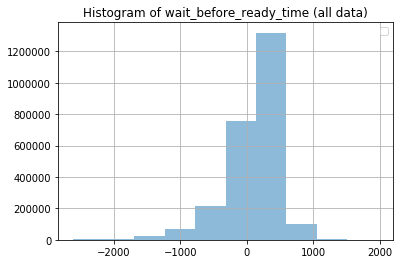

In [43]:
df_wait = df['wait_before_ready_time']
df_wait[(df_wait < df_wait.quantile(.9999)) & (df_wait > df_wait.quantile(.001))].hist(alpha=0.5)

plt.legend()
plt.title('Histogram of wait_before_ready_time (all data)')

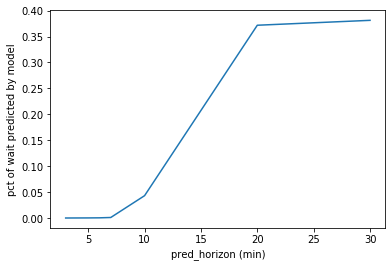

In [44]:
#check if predict 'no wait' when time is close to food ready time
pct = []
pred_horizon_thr = [3, 5, 6, 7, 10, 20, 30]
for thr in pred_horizon_thr:
  pct.append(check_if_no_wait(X_test, y_test, y_pred_default, thr))

plt.figure()
plt.plot(pred_horizon_thr, pct)
plt.xlabel('pred_horizon (min)')
plt.ylabel('pct of wait predicted by model')
display()

### Artificially change pred_horizon for randomly sampled data points

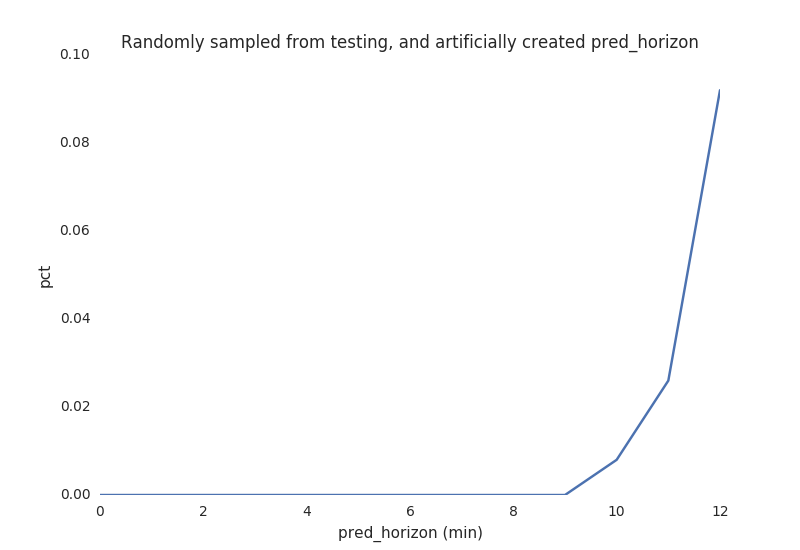

In [46]:
clf = clf_default
# if scaler_type == "minmax":
#   scaler = MinMaxScaler()  
# elif scaler_type == "standard":
#   scaler = StandardScaler()
# elif scaler_type == "normal": 
#   scaler = Normalizer()

test_sampled_index = X_test.sample(1000).index

X_test_sampled = X_test.loc[test_sampled_index].copy()
y_test_sampled = y_test.loc[test_sampled_index].copy()

res = []
ranges = range(0, 60*13, 60)
for var in ranges:
  # print(var)
  
  X_test_sampled_scaled = scale_data(X_train, X_test_sampled, SCALER_TYPE)
  
  X_test_sampled['pred_horizon'] = var
  # X_test_sampled_scaled = scaler.transform(X_test_sampled)
  _, X_test_sampled_scaled = scale_data(X_train, X_test_sampled, SCALER_TYPE)
  
  y_pred_sampled_scaled = clf.predict(X_test_sampled_scaled)
  y_pred_sampled_scaled_proba = clf.predict_proba(X_test_sampled_scaled)
  # eval_model(y_test_sampled, y_pred_sampled_scaled, y_pred_sampled_scaled_proba)
  res.append(y_pred_sampled_scaled)

res = np.array(res)
res_mean = res.mean(axis=1)

res_mean

plt.figure()
plt.plot(np.array(list(ranges))/60, res_mean)
# plt.plot(res[:, :10])
plt.title('Randomly sampled from testing, and artificially created pred_horizon')
plt.xlabel('pred_horizon (min)')
plt.ylabel('pct')
display()

### Bad false positives: Pred wait but actually late

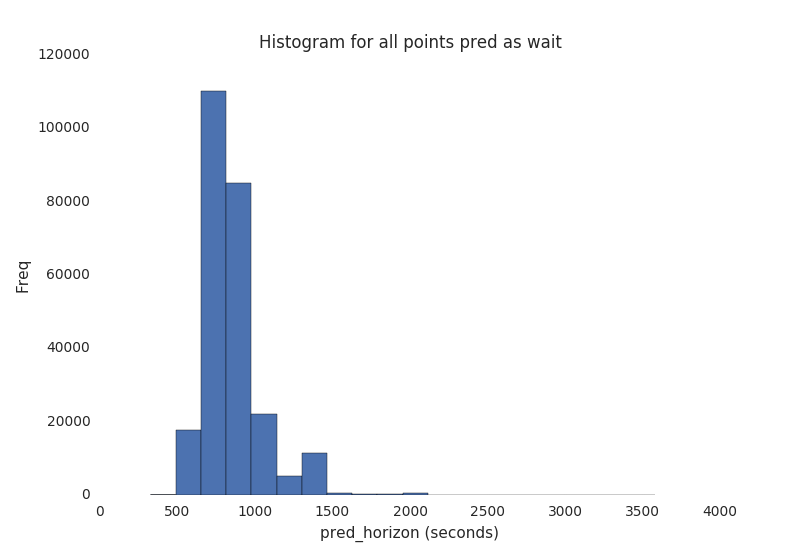

In [48]:

# def check_if_is_late(X, y, y_pred, late_thr):
#   late_index = X[X['wait_before_ready_time'] < -late_thr].index
#   df_y_pred = pd.DataFrame(data=y_pred, index=y.index)
#   pct = df_y_pred.loc[late_index].mean().values[0]
#   print(pct, 'are predicted as wait but is late by', late_thr, 'seconds')
#   return pct

# late_thr = [120, 240, 360, 480, 600, 720, 840, 960]

# pct = []
# for thr in late_thr:
#   pct.append(check_if_is_late(df.loc[test_index], y_test, y_pred, thr))

# # plt.plot(late_thr, pct)
# # plt.xlabel('late (seconds)')
# # plt.ylabel('pct of late but was predicted as wait')

df_test = df.loc[test_index]

df_y_pred = pd.DataFrame(data=y_pred_default, index=y_test.index, columns=['prediction'])
df_test_wait = df_y_pred[df_y_pred['prediction'] == True]
wait_index = df_test_wait.index

print('all test', df_test.shape, 'test_wait', wait_index.shape)

assert df_test.shape[0] > df_test_wait.shape[0], 'incorrect test and test_wait shape'

def get_late_pct(thr):
  df_test_late = df_test[df_test['wait_before_ready_time'] < -thr]
  late_index = df_test_late.index

  wait_and_late_index = wait_index.intersection(late_index)
  
  print('\t\tlate shape', late_index.shape, 'wait shape', wait_index.shape, 'wait_and_late shape', wait_and_late_index.shape)
  pct_allwait = wait_and_late_index.shape[0]/wait_index.shape[0]
  pct_alldata = wait_and_late_index.shape[0]/df.shape[0]

  return pct_allwait, pct_alldata

late_thr = [0, 1, 3, 5, 7, 10, 20]
pcts_allwait = []  
pcts_alldata = []
for thr in late_thr:
  pct_allwait, pct_alldata = get_late_pct(thr*60)
  print(thr, pct_allwait, pct_alldata)
  pcts_allwait.append(pct_allwait)
  pcts_alldata.append(pct_alldata)
  
plt.figure()
plt.plot(late_thr, pcts_allwait)
plt.xlabel('lateness by min')
plt.ylabel('pct of pred_wait_but_late / pred_wait ')

plt.figure()

plt.plot(late_thr, pcts_alldata)
plt.xlabel('lateness by min')
plt.ylabel('pct of pred_wait_but_late / all_data ')

plt.figure()
df.loc[wait_index]['pred_horizon'].hist(bins=20)
plt.title('Histogram for all points pred as wait')
plt.xlabel('pred_horizon (seconds)')
plt.ylabel('Freq')
print('min', df.loc[wait_index]['pred_horizon'].min(), 'mean', df.loc[wait_index]['pred_horizon'].mean())

df_test = df.loc[test_index]
df_test.loc[df_test['label'] == 'late', "pred_horizon"]
display()

### General model behavior

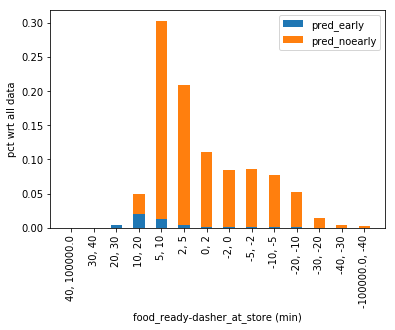

In [50]:

def get_stacked_bar(y_test, y_pred, y_test_time):
  res = pd.DataFrame()
  res['gt'] = y_test
  res['pred'] = y_pred_default
  res['time'] = y_test_time
  
  miss_index = res[res['gt'] != res['pred']].index
  
  out = []
  intervals = [1e5, 40, 30, 20, 10, 5, 2, 0, -2, -5, -10, -20, -30,  -40, -1e5]
  xlabel = []
  for i in range(len(intervals) - 1):
    low = intervals[i+1]
    high = intervals[i]
    xlabel.append(str(low) + ', ' + str(high))
    
    df_interval = res[(low*60 <= res['time']) & (res['time'] < high*60)]
    num_pred_early = df_interval[df_interval['pred'] == 1].shape[0]
    if high > 5:
      mean_time_pred_early = df_interval[df_interval['pred'] == 1]['time'].sum()
    else:
      mean_time_pred_early = 0
    num_pred_noearly = df_interval[df_interval['pred'] == 0].shape[0]
    if high <= 0:
      mean_time_pred_noearly = df_interval[df_interval['pred'] == 0]['time'].sum()
    else:
      mean_time_pred_noearly = 0
    
    
    num_interval = df_interval.shape[0]

    out.append([num_pred_early/len(res), num_pred_noearly/len(res), num_interval/len(res), mean_time_pred_early, mean_time_pred_noearly])
  out = np.array(out)

  print('ratio of total_wait_time (that can be saved) vs. total_late_time (that resulted by model:', out[:, 3].sum() / out[:, 4].sum())
  for i in range(len(xlabel)):
    print('interval', xlabel[i], 'pct predicted as early (wrt all data)', '{:.4f}'.format(out[i, 0]), \
          'pct predicted as nonearly (wrt all data)', '{:.4f}'.format(out[i, 1])) #,\
          # 'mean_time_pred_early', out[i, 3],
          # 'mean_time_pred_noearly', out[i, 4])
  fig, ax = plt.subplots()
  
  ax.bar(xlabel, out[:, 0], width=.5)
  ax.bar(xlabel, out[:, 1], width=.5, bottom=out[:, 0])
  
  plt.xticks(rotation=90)
  plt.legend(['pred_early', 'pred_noearly'])
  plt.xlabel('food_ready-dasher_at_store (min)')
  plt.ylabel('pct wrt all data')
get_stacked_bar(y_test, y_pred, y_test_time)

model_mean, model_std